# Agent Chat with Huggingface Models

## Set up the environment

In [1]:
%pip install huggingface_hub Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re

import PIL

import autogen
from autogen import UserProxyAgent
from autogen.agentchat.contrib.huggingface_agent import HuggingFaceAgent, HuggingFaceCapability
from autogen.agentchat.contrib.img_utils import get_pil_image
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

First, we need to specify the configurations for the HuggingFace models we want to use, like the model ID, API key, and inference mode. We can do this by extending the `OAI_CONFIG_LIST`.

The `config_list` of HuggingFace models in `OAI_CONFIG_LIST` should be something like:

```python
[
    {
        "model": "<HF_MODEL_ID_OR_URL>",
        "api_key": "<HF_API_KEY>",
        "inference_mode": "auto", # choose from ["local", "remote", "auto"]
        "api_type": "HuggingFace",
        "tags": ["<HF_TASK>"]
    }
]
```

In this sample notebook, we will use:
- the [stabilityai/sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) model for `text-to-image` task
- the [Salesforce/blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) model for `image-to-text` task
- the [stabilityai/stable-diffusion-xl-refiner-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-refiner-1.0) model for `image-to-image` task
- the [dandelin/vilt-b32-finetuned-vqa](https://huggingface.co/dandelin/vilt-b32-finetuned-vqa) model for `visual-question-answering` task.

In [3]:
gpt4_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4"]},
)

gpt4v_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4-turbo-vision"]},
)

text2image_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["HuggingFace"], "tags": ["text-to-image"]}
)

image2text_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["HuggingFace"], "tags": ["image-to-text"]}
)

image2image_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["HuggingFace"], "tags": ["image-to-image"]}
)

vqa_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["HuggingFace"], "tags": ["visual-question-answering"]}
)

We will create a config map with the key as one of the `HuggingFaceCapability`, and the value as the model config for the corresponding capability. This map will be later used to create the `HuggingFaceAgent`.

In [4]:
hf_capability_config_map = {
    HuggingFaceCapability.TEXT_TO_IMAGE: {"config_list": text2image_config_list},
    HuggingFaceCapability.IMAGE_TO_TEXT: {"config_list": image2text_config_list},
    HuggingFaceCapability.IMAGE_TO_IMAGE: {"config_list": image2image_config_list},
    HuggingFaceCapability.VISUAL_QUESTION_ANSWERING: {"config_list": vqa_config_list},
}

## Helper Functions

Here is a helper function to extract images from the messages.

In [5]:
def extract_images(sender: autogen.ConversableAgent, recipient: autogen.ConversableAgent) -> PIL.Image:
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", "")
        if isinstance(contents, str):
            for img_data in re.findall("<img (.*)>", contents):
                images.append(get_pil_image(img_data))
        else:
            for content in contents:
                if isinstance(content, str):
                    continue
                if content.get("type", "") == "image_url":
                    img_data = content["image_url"]["url"]
                    images.append(get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

## Simple Example: Call directly from User

In [6]:
assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    hf_capability_config_map=hf_capability_config_map,
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    is_gpt4v_format=True,
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="",
    is_termination_msg=lambda x: True,
)

### Text-To-Image

We can ask the `HuggingFaceAgent` to create an image with a text prompt.

In [7]:
user_proxy.initiate_chat(
    assistant,
    message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.",
)

user_proxy (to multimodal_assistant):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION TEXT_TO_IMAGE...
multimodal_assistant (to user_proxy):

Here is the image of a happy robot on a black background, holding a sign that says 'I Love AutoGen':

<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.", 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Here is the image of a happy robot on a black background, holding a sign that says 'I Love AutoGen':\n\n"}, {'type': 'image_url', 'image_url': {'url': <PIL.Image.Image image mode=RGB size=512x512 at 0x717F0A7ED360>}}, {'type': 'text', 'text': ''}], 'role': 'user'}], summary="Here is the image of a happy robot on a black background, holding a sign that says 'I Love AutoGen':\n\n\n", cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

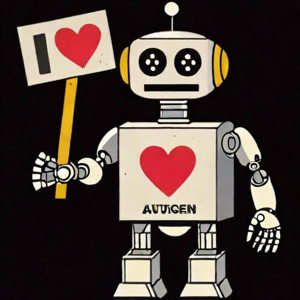

In [8]:
images = extract_images(assistant, user_proxy)

for image in reversed(images):
    display(image.resize((300, 300)))

### Image-To-Text

We can also ask the `HuggingFaceAgent` to describe the content of an image.

In [9]:
user_proxy.initiate_chat(
    assistant,
    message="""Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

user_proxy (to multimodal_assistant):

Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION IMAGE_TO_TEXT...
multimodal_assistant (to user_proxy):

Here's a poem for the image you provided:

In the quiet corners of the home he lays,
A small brown dog, through lazy days.
Fur of earth, eyes like mellowed wood,
In his simple presence, all feels good.

His gentle breaths, a soft whispering muse,
Around him, life’s colors vividly fuse.
Resting on cool tiles, a sigh released,
In these moments, the world's pace has ceased.

He dreams of fields, under skies so wide,
But for now, he’s content by the fireside.
A faithful companion, silent and dear,
Bringing hearts closer, dissolving any fear.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Write a poet for my image:\n    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Here's a poem for the image you provided:\n\nIn the quiet corners of the home he lays,\nA small brown dog, through lazy days.\nFur of earth, eyes like mellowed wood,\nIn his simple presence, all feels good.\n\nHis gentle breaths, a soft whispering muse,\nAround him, life’s colors vividly fuse.\nResting on cool tiles, a sigh released,\nIn these moments, the world's pace has ceased.\n\nHe dreams of fields, under skies so wide,\nBut for now, he’s content by the fireside.\nA faithful companion, silent and dear,\nBringing hearts closer, dissolving any fear."}], 'role': 'user'}], summary="Here's a poem for the image you provided:\n\nIn the quiet corners of the home he lays,\nA small brown dog, through lazy days.\nFur of earth, eyes like mellowed

### Visual-Question_Answering

We can also ask the `HuggingFaceAgent` to answer a question based on the content of the image.

We will show this image and ask a follow-up question.

![test_img](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [10]:
user_proxy.initiate_chat(
    assistant,
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
)

user_proxy (to multimodal_assistant):

What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION VISUAL_QUESTION_ANSWERING...
multimodal_assistant (to user_proxy):

The dog in the image is a husky.

Regarding your question about which breed barks less, generally speaking, huskies are known for being relatively quiet in terms of barking. However, they are known to howl. Each dog has individual behaviors, but by breed, huskies are less likely to bark frequently compared to some other breeds.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'What is this breed?\n<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>\n\nAmong the breeds, which one barks less?', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': 'The dog in the image is a husky.\n\nRegarding your question about which breed barks less, generally speaking, huskies are known for being relatively quiet in terms of barking. However, they are known to howl. Each dog has individual behaviors, but by breed, huskies are less likely to bark frequently compared to some other breeds.'}], 'role': 'user'}], summary='The dog in the image is a husky.\n\nRegarding your question about which breed barks less, generally speaking, huskies are known for being relatively quiet in terms of barking. However, they are known to howl. Each dog has individual behaviors, but by breed, huskies are less likely to bark frequently compared to some other breeds.', cost={'usage_including_cached_inference': {'t

## Example With Critics: Iterate several times to improve

In [11]:
CRITICS_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create an image that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

If you have no critique or a prompt, just say TERMINATE
"""


def _is_termination_message(msg) -> bool:
    # Detects if we should terminate the conversation
    if isinstance(msg.get("content"), str):
        return msg["content"].rstrip().endswith("TERMINATE")
    elif isinstance(msg.get("content"), list):
        for content in msg["content"]:
            if isinstance(content, dict) and "text" in content:
                return content["text"].rstrip().endswith("TERMINATE")
    return False


critic_agent = MultimodalConversableAgent(
    name="critic",
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    system_message=CRITICS_SYSTEM_MESSAGE,
    max_consecutive_auto_reply=1,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: _is_termination_message(msg),
)

image_creator = HuggingFaceAgent(
    name="image_creator",
    hf_capability_config_map=hf_capability_config_map,
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    is_gpt4v_format=True,
    is_termination_msg=lambda msg: _is_termination_message(msg),
)

In [12]:
critic_agent.initiate_chat(
    image_creator,
    message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.",
)

critic (to image_creator):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION TEXT_TO_IMAGE...
image_creator (to critic):

Here is the image of a happy robot showing a sign with 'I Love AutoGen' on a black background:

<image>

--------------------------------------------------------------------------------
critic (to image_creator):

CRITICS: The image needs improvement in text clarity on the sign the robot is holding. The words "I Love AutoGen" could be more vibrant and larger for better visibility.

PROMPT: Create an image featuring a cheerful robot on a black background, holding a sign that reads "I Love AutoGen." Enhance the text by making it bolder and more colorful, ensuring it stands out vividly against the sign's background. The robot should appear friendly and engag

ChatResult(chat_id=None, chat_history=[{'content': [{'type': 'text', 'text': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear."}], 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Here is the image of a happy robot showing a sign with 'I Love AutoGen' on a black background:\n\n"}, {'type': 'image_url', 'image_url': {'url': <PIL.Image.Image image mode=RGB size=512x512 at 0x7180082E8C70>}}, {'type': 'text', 'text': ''}], 'role': 'user'}, {'content': [{'type': 'text', 'text': 'CRITICS: The image needs improvement in text clarity on the sign the robot is holding. The words "I Love AutoGen" could be more vibrant and larger for better visibility.\n\nPROMPT: Create an image featuring a cheerful robot on a black background, holding a sign that reads "I Love AutoGen." Enhance the text by making it bolder and more colorful, ensuring it stands out vividly against the sign\'s background. The robot should appear f

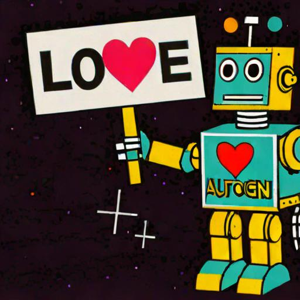

In [13]:
images = extract_images(image_creator, critic_agent)

display(images[0].resize((300, 300)))